# Capstone Project workbook - Allie Garrison


In [10]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
conn = sqlite3.connect('zippedData/im.db')

bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t',encoding='windows-1252')
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv")
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", parse_dates=['release_date'])

In [ ]:
rt_reviews.head()

In [ ]:
rt_reviews.info()

In [ ]:
bom_movie_gross.info()

In [ ]:
bom_movie_gross.head()

In [ ]:
rt_movie_info.info()

In [ ]:
rt_movie_info.head()

In [ ]:
tmdb_movies.info()

In [ ]:
tmdb_movies.head()

In [1]:
tn_movie_budgets.info()

NameError: name 'tn_movie_budgets' is not defined

In [ ]:
tn_movie_budgets.head()

In [ ]:
tn_movie_budgets.plot.bar('production_budget')

In [3]:
## Making copy of movie budgets data frame for cleaning
tn_movie_budgets_clean = tn_movie_budgets.copy()

## turning the columns with dollar amounts into int types in millions of dollars
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross_in_millions'].astype('int64') / 1000000

## keeping only the movies released after January 1, 2010
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['release_date'] >= "2010-01-01"]

## removing all the movies that made $0
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['domestic_gross_in_millions'] != 0]

In [4]:
## Calculating return on investment (ROI) for domestic and international revenue
tn_movie_budgets_clean['ROI_domestic'] = (tn_movie_budgets_clean['domestic_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean['ROI_international'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6,241.063875,1045.663875,58.710150,254.667286
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0,42.762350,149.762350,12.217814,42.789243
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6,459.005868,1403.013963,138.840250,424.384139
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317.0,620.181382,1316.721747,195.640815,415.369636
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220",306.0,936.662225,2053.311220,306.098766,671.016739


In [ ]:
q = '''
SELECT *
FROM persons
LEFT JOIN known_for k USING (person_id)
LEFT JOIN movie_basics m USING (movie_id)

'''

pd.read_sql(q, conn)

In [ ]:
pd.read_sql('''
SELECT  genres, COUNT() AS count_of_genres
FROM movie_basics
GROUP BY genres
ORDER BY count_of_genres DESC
''', conn)

In [7]:
table3 = pd.read_sql('''
SELECT  title
FROM movie_akas
WHERE is_original_title = 1

''', conn)

### 

In [9]:
## Joining the cleaned budget dataframe onto a queried dataframe from sql database on movie title
budget_w_sql = tn_movie_budgets_clean.merge(table3, how='inner', left_on='movie', right_on='title')

In [11]:
budget_w_sql.describe()

,id,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international
count,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000
mean,51.268657,44.242343,55.748024,139.093446,210.463647,417.476241
std,28.586335,54.611218,81.857288,224.332319,677.747145,1247.748458
min,1.000000,0.009000,0.000388,0.000528,0.003060,0.013800
25%,27.000000,9.000000,5.028911,11.463160,38.193487,96.451485
50%,51.000000,25.000000,28.789233,54.398944,96.800197,224.235561
75%,76.250000,55.000000,67.098325,157.464832,207.513787,412.027695
max,100.000000,410.600000,700.059566,2048.134200,22764.410000,41656.474000


In [5]:
table_genre = pd.read_sql('''
SELECT mb.primary_title, 
        mb.runtime_minutes, 
        mb.genres, 
        mr.averagerating,
        mr.numvotes
FROM movie_basics AS mb
JOIN movie_ratings AS mr USING (movie_id)
''', conn)

In [6]:
genre_ratings_budget = tn_movie_budgets_clean.merge(table_genre, how='inner', left_on='movie', right_on='primary_title')

In [19]:
genre_ratings_budget.head(15)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,primary_title,runtime_minutes,genres,averagerating,numvotes
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6,241.063875,1045.663875,58.710150,254.667286,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624
1,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0,42.762350,149.762350,12.217814,42.789243,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451
2,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6,459.005868,1403.013963,138.840250,424.384139,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594
3,7,2018-04-27,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",300.0,678.815482,2048.134200,226.271827,682.711400,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926
4,9,2017-11-17,Justice League,"$300,000,000","$229,024,295","$655,945,209",300.0,229.024295,655.945209,76.341432,218.648403,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135
5,10,2015-11-06,Spectre,"$300,000,000","$200,074,175","$879,620,923",300.0,200.074175,879.620923,66.691392,293.206974,Spectre,148.0,"Action,Adventure,Thriller",6.8,352504
6,11,2012-07-20,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099",275.0,448.139099,1084.439099,162.959672,394.341491,The Dark Knight Rises,164.0,"Action,Thriller",8.4,1387769
7,12,2018-05-25,Solo: A Star Wars Story,"$275,000,000","$213,767,512","$393,151,347",275.0,213.767512,393.151347,77.733641,142.964126,Solo: A Star Wars Story,135.0,"Action,Adventure,Fantasy",7.0,226243
8,13,2013-07-02,The Lone Ranger,"$275,000,000","$89,302,115","$260,002,115",275.0,89.302115,260.002115,32.473496,94.546224,The Lone Ranger,150.0,"Action,Adventure,Western",6.4,208827
9,14,2012-03-09,John Carter,"$275,000,000","$73,058,679","$282,778,100",275.0,73.058679,282.778100,26.566792,102.828400,John Carter,132.0,"Action,Adventure,Sci-Fi",6.6,241792


In [16]:
genre_ratings_budget.describe()

,id,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,runtime_minutes,averagerating,numvotes
count,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1803.000000,1843.000000,1.843000e+03
mean,51.271297,43.340034,55.352753,137.497935,203.748145,405.027100,106.063783,6.379870,9.819755e+04
std,28.849608,53.914519,82.861029,226.631164,632.528092,1164.718885,19.685396,1.044827,1.544851e+05
min,1.000000,0.009000,0.000388,0.000528,0.003060,0.013800,3.000000,1.600000,5.000000e+00
25%,27.000000,9.000000,4.050486,11.329520,35.245969,91.314365,93.000000,5.800000,4.725500e+03
50%,51.000000,22.000000,27.695246,52.460543,94.733433,220.585212,104.000000,6.500000,4.215400e+04
75%,77.000000,52.000000,67.061228,152.417957,205.204881,409.060377,117.000000,7.100000,1.187285e+05
max,100.000000,410.600000,700.059566,2048.134200,22764.410000,41656.474000,280.000000,9.200000,1.841066e+06


<AxesSubplot:>

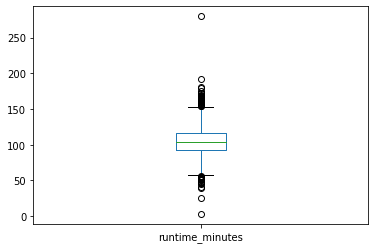

In [7]:
genre_ratings_budget.runtime_minutes.plot.box()

In [26]:
action = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Drama') == True]
avg_rating = genre_ratings_budget['averagerating'].mean()
avg_rating, action['averagerating'].mean()

(6.3798697775366255, 6.57376705141658)

In [27]:
stats.ttest_1samp(action['averagerating'], popmean=avg_rating)

Ttest_1sampResult(statistic=6.2811332889315565, pvalue=5.104686292106274e-10)

In [25]:
genre_ratings_budget.genres.describe()

count      1835
unique      252
top       Drama
freq        137
Name: genres, dtype: object